<!-- # Stitching Tutorial

The Workflow of the Stitching Pipeline can be seen in the following. Note that the image comes from the [OpenCV Documentation](https://docs.opencv.org/3.4/d1/d46/group__stitching.html).

![image stitching pipeline](https://github.com/opencv/opencv/blob/master/modules/stitching/doc/StitchingPipeline.jpg?raw=true) -->

In [ ]:
"""
Author: Huanhuan Zhao
Date of Creation: March 2025

This notebook demonstrates a pipeline of how to leverage two-channel images to enhance the stitching quality of a primary image channel.The Stitching package provides all necessary modules for image stitching: https://github.com/OpenStitching/stitching_tutorial/blob/master/Stitching%20Tutorial.ipynb

This code demonstrates two datasets, showing amplitude channel aided and differential channel aided image stitching.

Dependencies:
Need to install OpenCV library and stitching


"""

In [13]:
# pip install stitching
from stitching.subsetter import Subsetter
from stitching.camera_estimator import CameraEstimator
from stitching.camera_adjuster import CameraAdjuster
from stitching.camera_wave_corrector import WaveCorrector
from stitching.images import Images
from stitching.feature_detector import FeatureDetector
from stitching.feature_matcher import FeatureMatcher
from stitching.warper import Warper
from stitching.cropper import Cropper
from stitching.seam_finder import SeamFinder

from stitching.blender import Blender



<font size="5">  The following block is used to display images within the notebook:

In [14]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import os
import gwyfile
import cv2

def plot_image(img, figsize_in_inches=(5,5)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

def plot_images(imgs, figsize_in_inches=(5,5)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()


<font size="5"> The following block is used to load and sort the imgs to ensure images from these two channel are loaded in the same order

In [15]:
def load_images(path):
    files= os.listdir(path)
    images_path = [os.path.join(path, i) for i in files]
    len(images_path)
    sorted_files = sorted(
        images_path,
        key=lambda x: int(x.split('_')[-1].split('.')[0]))

    return sorted_files


Data- Pantoea sp. YR343 sample
    
- Dataset 1- The strain was grown in minimal media on a silicon oxide substrate between **4 and 6 hours**.
- Dataset 2 - The strain was grown in minimal media on a silicon oxide substrate for **30 mins**.

<font size="10">  Dataset 1 -- showing amplitude channel-aided image stitching

<font size="5"> **1. Path to the first imaging channel which is channel of interest. Eg. topographical channel images**

In [ ]:
# BioFilm topography
path2 = 'dataset1/topography/'
topo_imgs = load_images(path2)

<font size="5"> **2. Path to the second imaging channel, which is highly correlated to first imaging channel and feature rich. Eg. amplitude or differential channel images**

In [ ]:
path1 = 'dataset1/amplitude/'
amplitude_imgs = load_images(path1)

<font size="5"> **3. Load and resize the second channel (eg. amplitude/differential) images**

In [ ]:
images = Images.of(amplitude_imgs)
medium_imgs = list(images.resize(Images.Resolution.MEDIUM))
low_imgs = list(images.resize(Images.Resolution.LOW))
final_imgs = list(images.resize(Images.Resolution.FINAL))

In [ ]:
original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

print(f"Original Size: {original_size}  -> {'{:,}'.format(np.prod(original_size))} px ~ 1 MP")
print(f"Medium Size:   {medium_size}  -> {'{:,}'.format(np.prod(medium_size))} px ~ 0.6 MP")
print(f"Low Size:      {low_size}   -> {'{:,}'.format(np.prod(low_size))} px ~ 0.1 MP")
print(f"Final Size:    {final_size}  -> {'{:,}'.format(np.prod(final_size))} px ~ 1 MP")

Original Size: (1024, 1024)  -> 1,048,576 px ~ 1 MP
Medium Size:   (995, 995)  -> 990,025 px ~ 0.6 MP
Low Size:      (316, 316)   -> 99,856 px ~ 0.1 MP
Final Size:    (1024, 1024)  -> 1,048,576 px ~ 1 MP


<font size="5"> **4. Feature detection of second (eg.amplitude/differential) channel images**

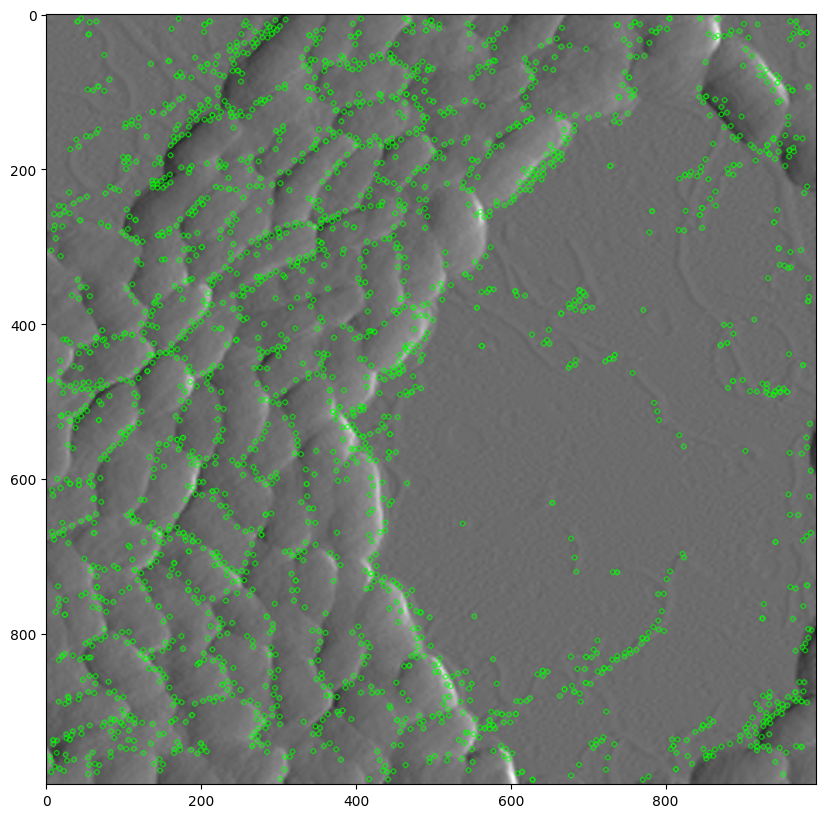

2289
2612
3090
2035
2075
2682
2959
3751
3838


np.float64(2814.5555555555557)

In [ ]:

#adjust the contrastThreshold and edgeThreshold to increase the detected feature
finder = FeatureDetector(detector="sift",nfeatures = 0, contrastThreshold=0.015, edgeThreshold = 15)
features = [finder.detect_features(img) for img in medium_imgs]
keypoints_center_img = finder.draw_keypoints(medium_imgs[0], features[0])
plot_image(keypoints_center_img, (15,10))
num_features = []
for i in range(len(features)):
    keypoints_center_img = finder.draw_keypoints(medium_imgs[i], features[i])
    #check the number of detected features
    # plot_image(keypoints_center_img, (15,10))
    print(len(features[i].keypoints))
    num_features.append(len(features[i].keypoints))
np.average(num_features)

<font size="5"> **5. Feature matching of second (amplitude/differential) channel images**

In [ ]:
matcher = FeatureMatcher(matcher_type='affine')
matches = matcher.match_features(features)

In [ ]:
# total matched keypoints
inlier = []
for i in range(len(matches)):
    if matches[i].num_inliers > 10 :
        inlier.append(matches[i].num_inliers)
np.sum(inlier)

np.int64(2022)

Matches Image 2 to Image 3


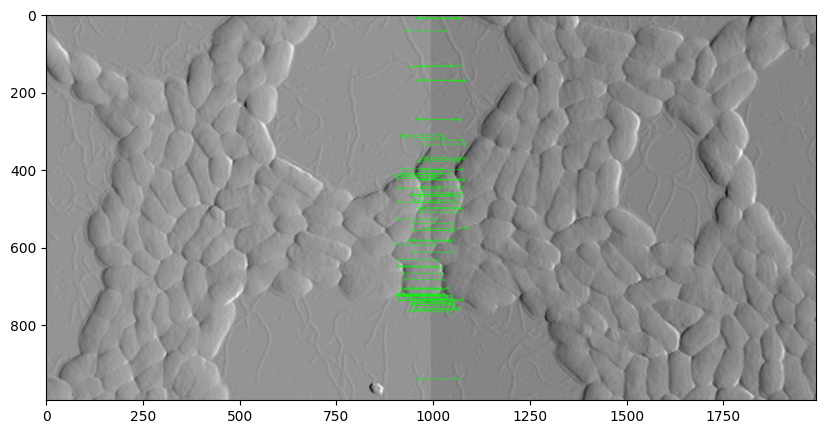

Matches Image 2 to Image 5


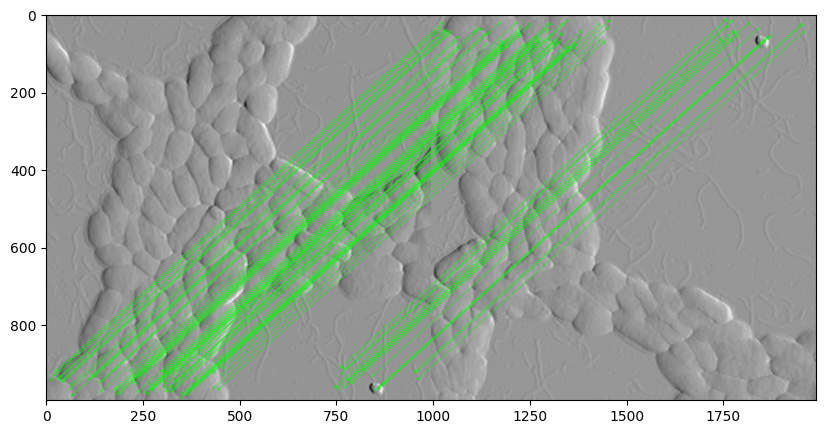

Matches Image 3 to Image 6


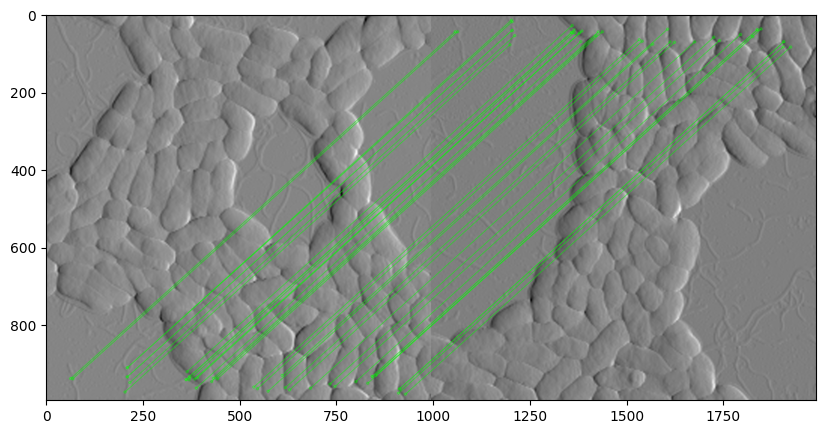

Matches Image 4 to Image 5


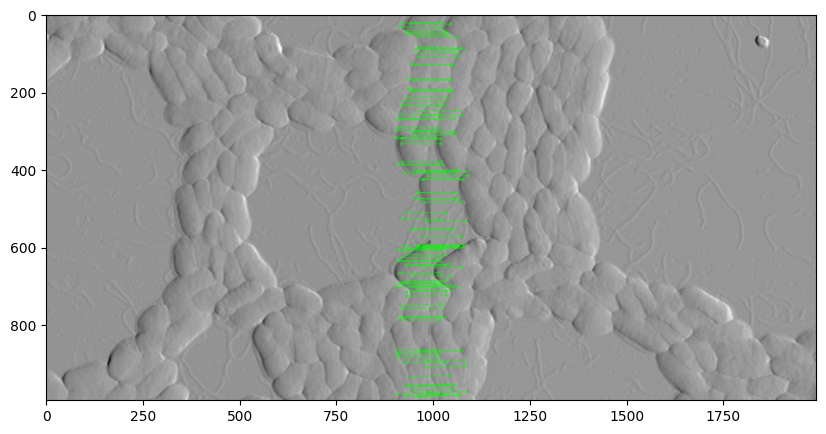

Matches Image 4 to Image 7


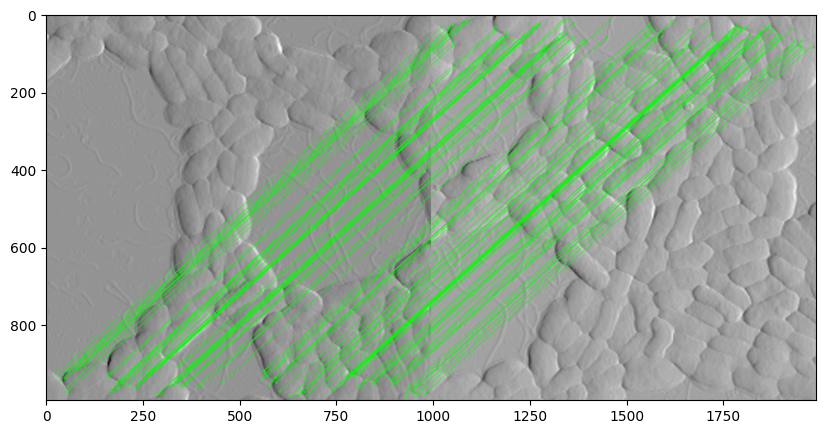

Matches Image 5 to Image 6


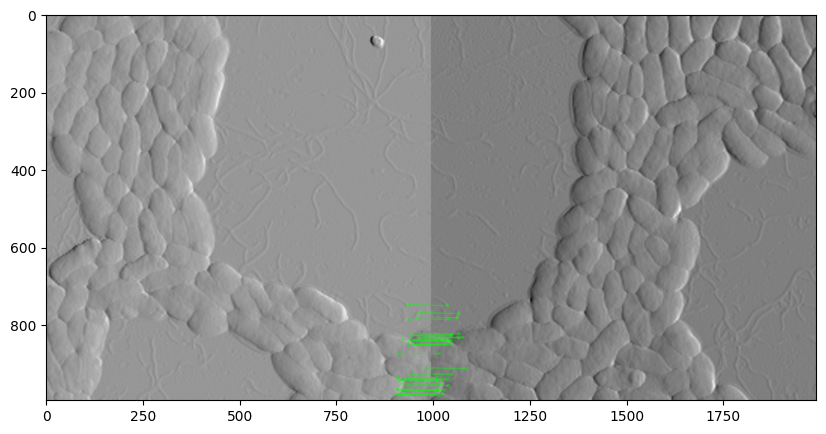

Matches Image 5 to Image 8


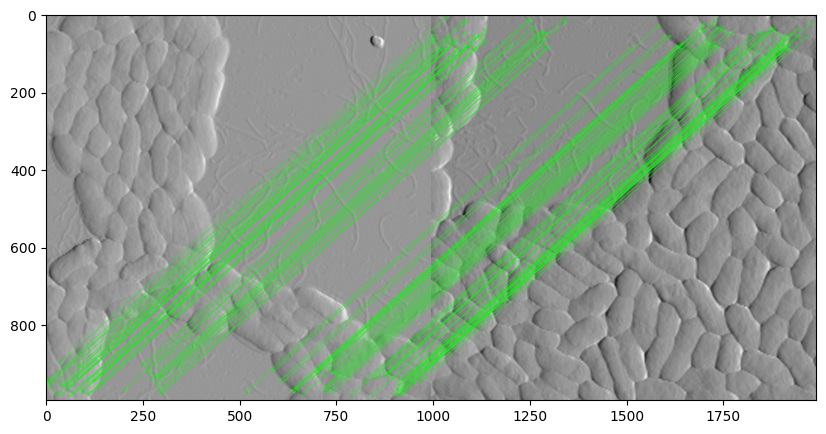

Matches Image 6 to Image 9


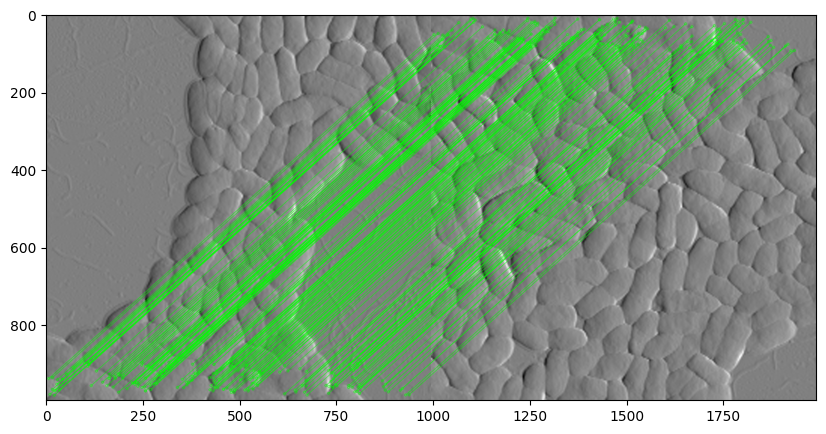

Matches Image 7 to Image 8


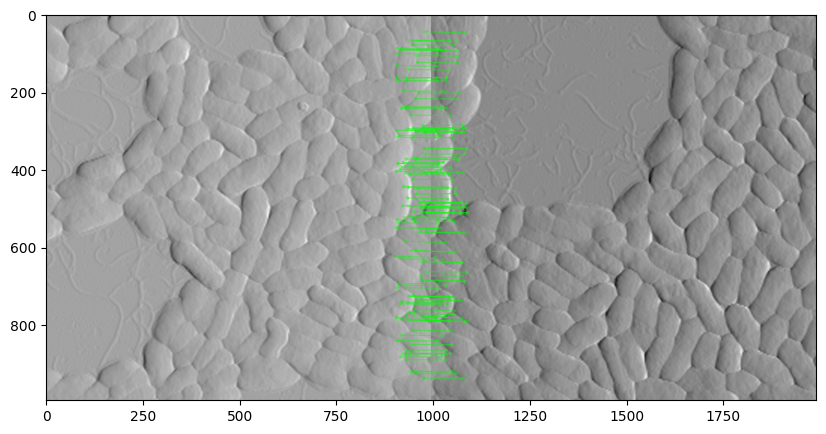

Matches Image 8 to Image 9


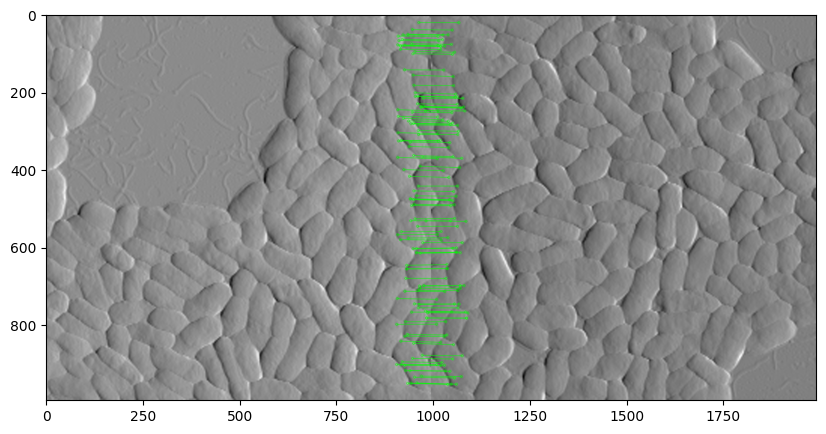

10


In [ ]:
# visualize the matches
all_relevant_matches = matcher.draw_matches_matrix(medium_imgs, features, matches, conf_thresh=0.5,
                                                   inliers=True, matchColor=(0, 255, 0))
count = 0
for idx1, idx2, img in all_relevant_matches:
    count += 1
    print(f"Matches Image {idx1+1} to Image {idx2+1}")
    plot_image(img, (10,5))
print(count)

<font size="5"> **6. Remove images that do not have any matched/connected images**

In [ ]:
subsetter = Subsetter(confidence_threshold=0.4)
dot_notation = subsetter.get_matches_graph(images.names, matches)

In [ ]:
indices = subsetter.get_indices_to_keep(features, matches)
medium_imgs = subsetter.subset_list(medium_imgs, indices)
low_imgs = subsetter.subset_list(low_imgs, indices)
final_imgs = subsetter.subset_list(final_imgs, indices)
features = subsetter.subset_list(features, indices)
matches = subsetter.subset_matches(matches, indices)
images.subset(indices)
print(matcher.get_confidence_matrix(matches))

[[0.         0.44334975 0.11363636 0.35       0.20942408 0.15957447
  0.09708738 0.08264463 0.09174312]
 [0.44334975 0.         1.58953722 0.45627376 1.7611336  0.11538462
  0.11538462 0.11673152 0.23648649]
 [0.11363636 1.58953722 0.         0.11673152 0.30418251 1.00543478
  0.17421603 0.14545455 0.20895522]
 [0.35       0.45627376 0.11673152 0.         1.88429752 0.08474576
  1.94029851 0.39145907 0.21818182]
 [0.20942408 1.7611336  0.30418251 1.88429752 0.         0.93247588
  0.38135593 1.85958254 0.49822064]
 [0.15957447 0.11538462 1.00543478 0.08474576 0.93247588 0.
  0.25454545 0.36363636 2.11009174]
 [0.09708738 0.11538462 0.17421603 1.94029851 0.38135593 0.25454545
  0.         1.92582026 0.23076923]
 [0.08264463 0.11673152 0.14545455 0.39145907 1.85958254 0.36363636
  1.92582026 0.         1.71749599]
 [0.09174312 0.23648649 0.20895522 0.21818182 0.49822064 2.11009174
  0.23076923 1.71749599 0.        ]]


<font size="5"> **7. Camera pose initialization and estimation**

In [ ]:
camera_estimator = CameraEstimator(estimator='affine')
camera_adjuster = CameraAdjuster(adjuster='affine')
wave_corrector = WaveCorrector(wave_correct_kind="no")
cameras = camera_estimator.estimate(features, matches)

In [ ]:
cameras = camera_adjuster.adjust(features, matches, cameras)
cameras = wave_corrector.correct(cameras)

<font size="5"> **8. Image warping of second channel images**

In [ ]:
warper = Warper(warper_type="affine")
warper.set_scale(cameras)

In [ ]:
low_sizes = images.get_scaled_img_sizes(Images.Resolution.LOW)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.LOW)  # since cameras were obtained on medium imgs

warped_low_imgs = list(warper.warp_images(low_imgs, cameras, camera_aspect))
warped_low_masks = list(warper.create_and_warp_masks(low_sizes, cameras, camera_aspect))
low_corners, low_sizes = warper.warp_rois(low_sizes, cameras, camera_aspect)

In [ ]:
final_sizes = images.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

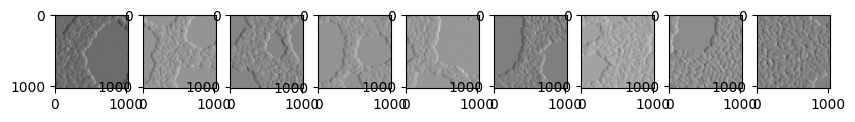

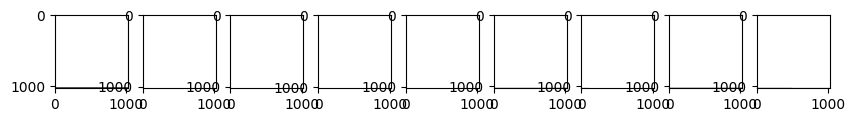

In [ ]:
plot_images(warped_final_imgs, (10,10))
plot_images(warped_final_masks, (10,10))

<font size="5"> **9. Image cropping of second channel images**

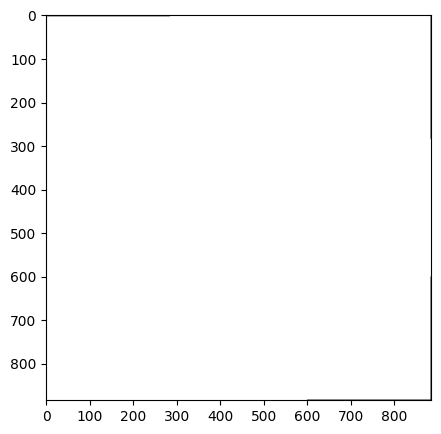

In [ ]:

cropper = Cropper()

mask = cropper.estimate_panorama_mask(warped_low_imgs, warped_low_masks, low_corners, low_sizes)
plot_image(mask, (5,5))

In [ ]:
cropper.prepare(warped_low_imgs, warped_low_masks, low_corners, low_sizes)


/home/huanhuan/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
cropped_low_masks = list(cropper.crop_images(warped_low_masks))
cropped_low_imgs = list(cropper.crop_images(warped_low_imgs))
low_corners, low_sizes = cropper.crop_rois(low_corners, low_sizes)

In [ ]:
lir_aspect = images.get_ratio(Images.Resolution.LOW, Images.Resolution.FINAL)  # since lir was obtained on low imgs
cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

 <font size="5"> **Note: So far we have estimated a panorama canvas and the transformation matrix for each of the images, we can directly go to Step 10**

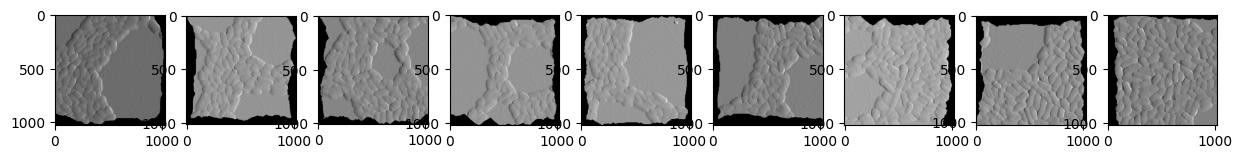

In [ ]:

seam_finder = SeamFinder()

seam_masks = seam_finder.find(cropped_final_imgs, final_corners, cropped_final_masks)
seam_masks = [seam_finder.resize(seam_mask, mask) for seam_mask, mask in zip(seam_masks, cropped_final_masks)]

seam_masks_plots = [SeamFinder.draw_seam_mask(img, seam_mask) for img, seam_mask in zip(cropped_final_imgs, seam_masks)]
plot_images(seam_masks_plots, (15,10))

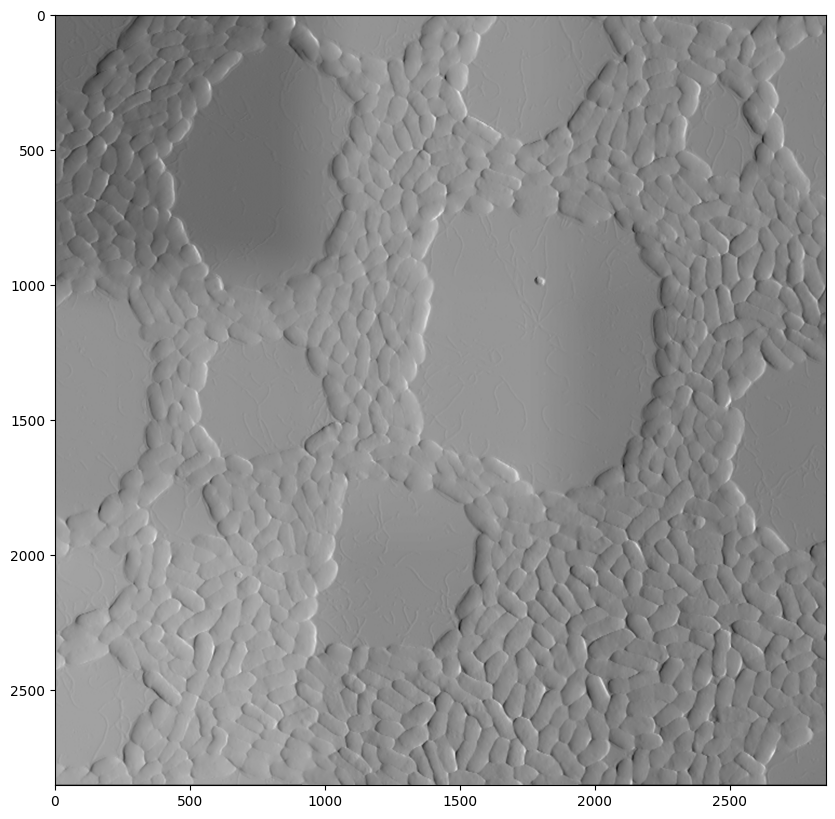

In [ ]:
blender = Blender()
blender.prepare(final_corners, final_sizes)
# for img, mask, corner in zip(cropped_final_imgs,seam_masks, final_corners):
for img, mask, corner in zip(cropped_final_imgs,cropped_final_masks, final_corners):

    blender.feed(img, mask, corner)
panorama, _ = blender.blend()
plot_image(panorama, (10,10))

<font size="5"> **10. Load and resize the first channel images of interest (eg. topographical images)**

In [ ]:
images_topo = Images.of(topo_imgs)
original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

print(f"Original Size: {original_size}  -> {'{:,}'.format(np.prod(original_size))} px ~ 1 MP")
print(f"Medium Size:   {medium_size}  -> {'{:,}'.format(np.prod(medium_size))} px ~ 0.6 MP")
print(f"Low Size:      {low_size}   -> {'{:,}'.format(np.prod(low_size))} px ~ 0.1 MP")
print(f"Final Size:    {final_size}  -> {'{:,}'.format(np.prod(final_size))} px ~ 1 MP")

medium_imgs_topo = list(images_topo.resize(Images.Resolution.MEDIUM))
low_imgs_topo = list(images_topo.resize(Images.Resolution.LOW))
final_imgs_topo = list(images_topo.resize(Images.Resolution.FINAL))

medium_imgs_topo = subsetter.subset_list(medium_imgs_topo, indices)
low_imgs_topo = subsetter.subset_list(low_imgs_topo, indices)
final_imgs_topo = subsetter.subset_list(final_imgs_topo, indices)

Original Size: (1024, 1024)  -> 1,048,576 px ~ 1 MP
Medium Size:   (995, 995)  -> 990,025 px ~ 0.6 MP
Low Size:      (316, 316)   -> 99,856 px ~ 0.1 MP
Final Size:    (1024, 1024)  -> 1,048,576 px ~ 1 MP


<font size="5"> **11. Warp the topographical images using the camera poses estimated by the second channel (amplitude/differential) images**

In [ ]:
final_sizes = images_topo.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images_topo.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs_topo, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

<font size="5">  **12. Crop the topographical images using the cropping parameters estimated from the second channel (amplitude/differential) images.**

In [ ]:
cropped_low_masks = list(cropper.crop_images(warped_low_masks))
cropped_low_imgs = list(cropper.crop_images(warped_low_imgs))
low_corners, low_sizes = cropper.crop_rois(low_corners, low_sizes)

In [ ]:
lir_aspect = images.get_ratio(Images.Resolution.LOW, Images.Resolution.FINAL)  # since lir was obtained on low imgs
cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

<font size="5">  **13. Blend topographical images together**

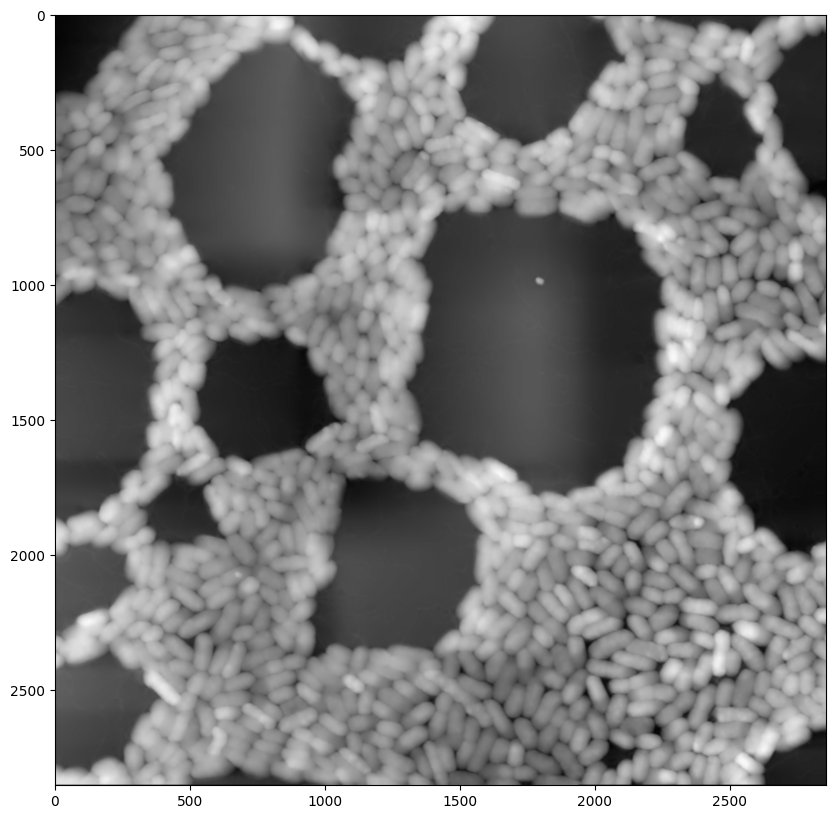

In [ ]:
#compensor is computational expensive and cause kernel crush, this code stitch images without compensor
blender = Blender()
blender.prepare(final_corners, final_sizes)
for img, mask, corner in zip(cropped_final_imgs, cropped_final_masks, final_corners):
    blender.feed(img, mask, corner)
panorama, _ = blender.blend()
plot_image(panorama, (10,10))

 <font size="10"> Dataset 2 -- showing differential channel-aided image stitching

 <font size="5">   **1. Path to the topographical channel images**

In [8]:
path2 = 'dataset2/topography/'
topo_imgs = load_images(path2)

 <font size="5">   **2. Path to the differentiation channel images**

In [ ]:
path1 = 'dataset2/grad_x'
amplitude_imgs = load_images(path1)

 <font size="5">   **3. load and resize differentiation channel images**

In [ ]:
# load amplitude data or topography data here
images = Images.of(amplitude_imgs)

medium_imgs = list(images.resize(Images.Resolution.MEDIUM))
low_imgs = list(images.resize(Images.Resolution.LOW))
final_imgs = list(images.resize(Images.Resolution.FINAL))

original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

<font size="5">  **4. Feature detection of differential images**

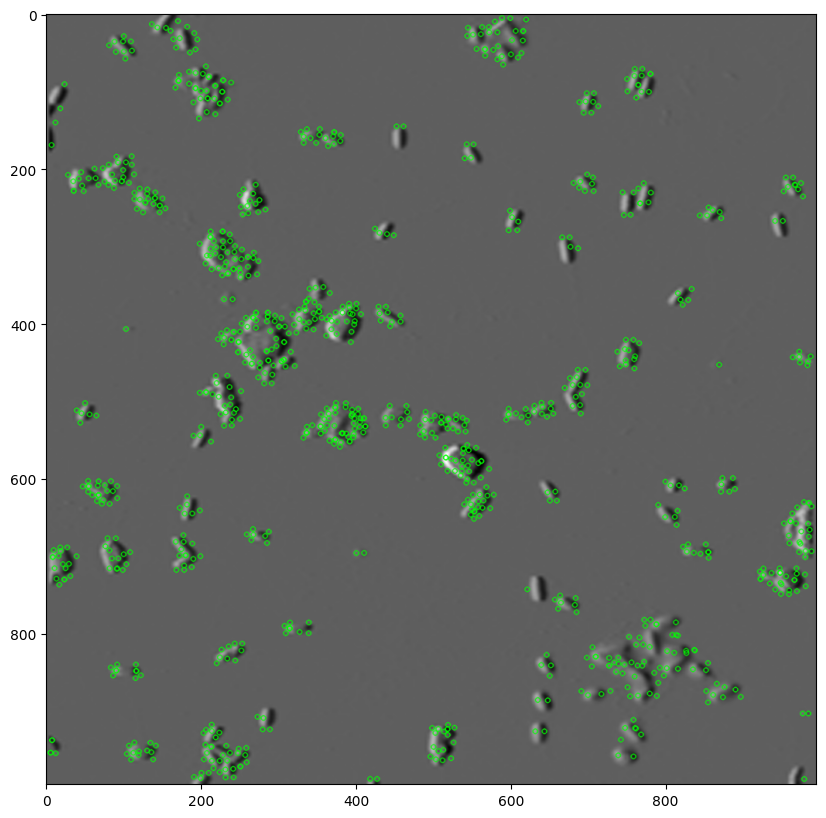

In [ ]:
#adjust the contrastThreshold and edgeThreshold to increase the detected feature
finder = FeatureDetector(detector="sift",nfeatures = 0, contrastThreshold=0.015, edgeThreshold = 15)
features = [finder.detect_features(img) for img in medium_imgs]
keypoints_center_img = finder.draw_keypoints(medium_imgs[0], features[0])
plot_image(keypoints_center_img, (15,10))


<font size="5">  **5. Feature matching of differential images**

In [ ]:
matcher = FeatureMatcher(matcher_type='affine')
matches = matcher.match_features(features)

<font size="5">  **6. Remove images that do not have any matched images**

In [ ]:
subsetter = Subsetter(confidence_threshold=0.4)
dot_notation = subsetter.get_matches_graph(images.names, matches)
indices = subsetter.get_indices_to_keep(features, matches)
medium_imgs = subsetter.subset_list(medium_imgs, indices)
low_imgs = subsetter.subset_list(low_imgs, indices)
final_imgs = subsetter.subset_list(final_imgs, indices)
features = subsetter.subset_list(features, indices)
matches = subsetter.subset_matches(matches, indices)
images.subset(indices)

<font size="5">  **7. Camera pose initialization and estimation**

In [ ]:

camera_estimator = CameraEstimator(estimator='affine')
camera_adjuster = CameraAdjuster(adjuster='affine')
wave_corrector = WaveCorrector(wave_correct_kind="no")

cameras = camera_estimator.estimate(features, matches)

In [ ]:
cameras = camera_adjuster.adjust(features, matches, cameras)
cameras = wave_corrector.correct(cameras)

<font size="5"> **8. image warping**

In [ ]:
warper = Warper(warper_type="affine")
warper.set_scale(cameras)

In [ ]:
low_sizes = images.get_scaled_img_sizes(Images.Resolution.LOW)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.LOW)  # since cameras were obtained on medium imgs

warped_low_imgs = list(warper.warp_images(low_imgs, cameras, camera_aspect))
warped_low_masks = list(warper.create_and_warp_masks(low_sizes, cameras, camera_aspect))
low_corners, low_sizes = warper.warp_rois(low_sizes, cameras, camera_aspect)

In [ ]:
final_sizes = images.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

<font size="5"> **9. image cropping**

In [ ]:
cropper = Cropper()
mask = cropper.estimate_panorama_mask(warped_low_imgs, warped_low_masks, low_corners, low_sizes)

In [ ]:
cropper.prepare(warped_low_imgs, warped_low_masks, low_corners, low_sizes)

In [ ]:
cropped_low_masks = list(cropper.crop_images(warped_low_masks))
cropped_low_imgs = list(cropper.crop_images(warped_low_imgs))
low_corners, low_sizes = cropper.crop_rois(low_corners, low_sizes)

In [ ]:
lir_aspect = images.get_ratio(Images.Resolution.LOW, Images.Resolution.FINAL)  # since lir was obtained on low imgs
cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

<font size="5"> **10. Load the topographical images**

In [ ]:
images_topo = Images.of(topo_imgs)
original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

medium_imgs_topo = list(images_topo.resize(Images.Resolution.MEDIUM))
low_imgs_topo = list(images_topo.resize(Images.Resolution.LOW))
final_imgs_topo = list(images_topo.resize(Images.Resolution.FINAL))

medium_imgs_topo = subsetter.subset_list(medium_imgs_topo, indices)
low_imgs_topo = subsetter.subset_list(low_imgs_topo, indices)
final_imgs_topo = subsetter.subset_list(final_imgs_topo, indices)

<font size="5"> **11. Warp the topographical images using the camera poses estimated by the differential images**

In [ ]:
final_sizes = images_topo.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images_topo.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs_topo, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

<font size="5"> **12. Crop the topographical images using the cropping parameters estimated from differential images**

In [ ]:
cropped_low_masks = list(cropper.crop_images(warped_low_masks))
cropped_low_imgs = list(cropper.crop_images(warped_low_imgs))
low_corners, low_sizes = cropper.crop_rois(low_corners, low_sizes)

In [ ]:
lir_aspect = images.get_ratio(Images.Resolution.LOW, Images.Resolution.FINAL)  # since lir was obtained on low imgs
cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

<font size="5"> **13. Blend topographical images together**

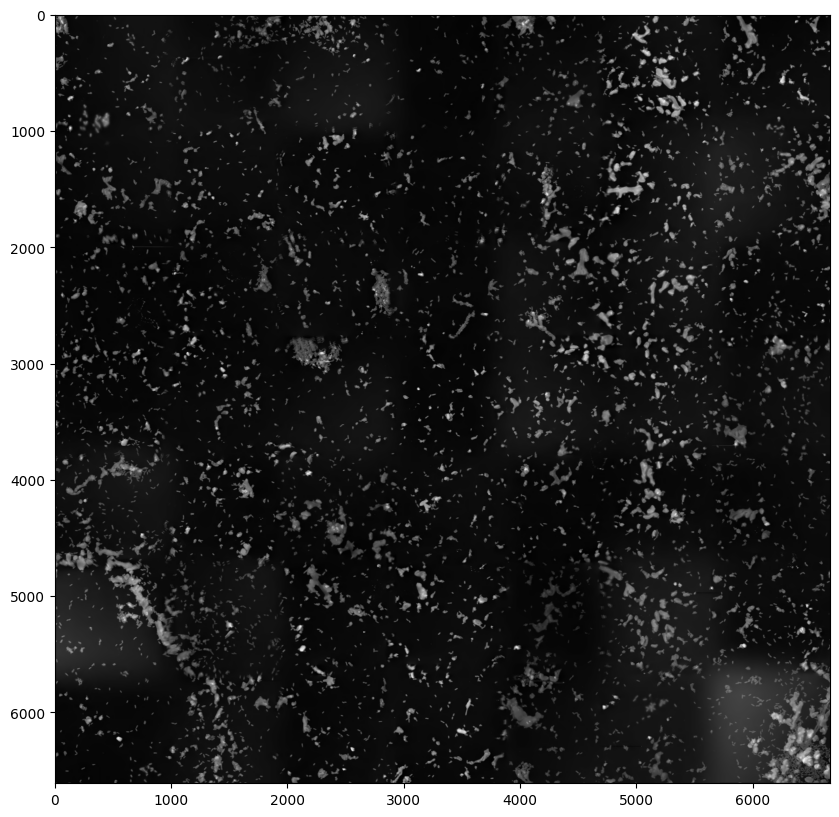

In [ ]:
#compensor is computational expensive and cause kernel crush, this code stitch images without compensor
blender = Blender()
blender.prepare(final_corners, final_sizes)
for img, mask, corner in zip(cropped_final_imgs, cropped_final_masks, final_corners):
    blender.feed(img, mask, corner)
panorama, _ = blender.blend()
plot_image(panorama, (10,10))

<font size="10">  Dataset 3 -- showing phase channel-aided image stitching

 <font size="5">   **1. Path to the topographical channel images**

In [10]:
path2 = 'PFM/Topo/'
topo_imgs = load_images(path2)

 <font size="5">   **2. Path to the phase channel images**

In [11]:
path1 = 'PFM/Phase/'
phase_imgs = load_images(path1)

 <font size="5">   **3. load and resize phase channel images**

In [16]:
# load amplitude data or topography data here
images = Images.of(phase_imgs)

medium_imgs = list(images.resize(Images.Resolution.MEDIUM))
low_imgs = list(images.resize(Images.Resolution.LOW))
final_imgs = list(images.resize(Images.Resolution.FINAL))

original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

<font size="5">  **4. Feature detection of phase images**

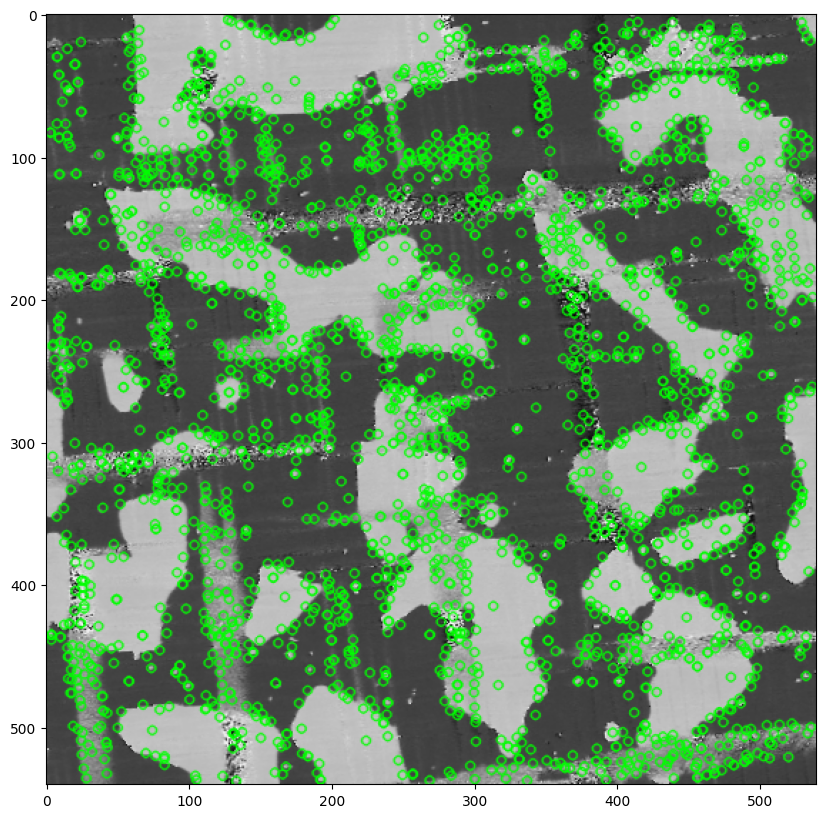

In [17]:
#adjust the contrastThreshold and edgeThreshold to increase the detected feature
finder = FeatureDetector(detector="sift",nfeatures = 0, contrastThreshold=0.015, edgeThreshold = 15)
features = [finder.detect_features(img) for img in medium_imgs]
keypoints_center_img = finder.draw_keypoints(medium_imgs[0], features[0])
plot_image(keypoints_center_img, (15,10))

<font size="5">  **5. Feature matching of phase images**

In [18]:
matcher = FeatureMatcher(matcher_type='affine')
matches = matcher.match_features(features)

<font size="5">  **6. Remove images that do not have any matched images**

In [19]:
subsetter = Subsetter(confidence_threshold=0.4)
dot_notation = subsetter.get_matches_graph(images.names, matches)
indices = subsetter.get_indices_to_keep(features, matches)
medium_imgs = subsetter.subset_list(medium_imgs, indices)
low_imgs = subsetter.subset_list(low_imgs, indices)
final_imgs = subsetter.subset_list(final_imgs, indices)
features = subsetter.subset_list(features, indices)
matches = subsetter.subset_matches(matches, indices)
images.subset(indices)

<font size="5">  **7. Camera pose initialization and estimation**

In [20]:

camera_estimator = CameraEstimator(estimator='affine')
camera_adjuster = CameraAdjuster(adjuster='affine')
wave_corrector = WaveCorrector(wave_correct_kind="no")

cameras = camera_estimator.estimate(features, matches)

In [21]:
cameras = camera_adjuster.adjust(features, matches, cameras)
cameras = wave_corrector.correct(cameras)

<font size="5"> **8. image warping**

In [22]:
warper = Warper(warper_type="affine")
warper.set_scale(cameras)

In [23]:
low_sizes = images.get_scaled_img_sizes(Images.Resolution.LOW)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.LOW)  # since cameras were obtained on medium imgs

warped_low_imgs = list(warper.warp_images(low_imgs, cameras, camera_aspect))
warped_low_masks = list(warper.create_and_warp_masks(low_sizes, cameras, camera_aspect))
low_corners, low_sizes = warper.warp_rois(low_sizes, cameras, camera_aspect)

In [24]:
final_sizes = images.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

<font size="5"> **9. image cropping**

In [25]:
cropper = Cropper()
mask = cropper.estimate_panorama_mask(warped_low_imgs, warped_low_masks, low_corners, low_sizes)

In [26]:
cropper.prepare(warped_low_imgs, warped_low_masks, low_corners, low_sizes)

/home/huanhuan/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [27]:
cropped_low_masks = list(cropper.crop_images(warped_low_masks))
cropped_low_imgs = list(cropper.crop_images(warped_low_imgs))
low_corners, low_sizes = cropper.crop_rois(low_corners, low_sizes)

In [28]:
lir_aspect = images.get_ratio(Images.Resolution.LOW, Images.Resolution.FINAL)  # since lir was obtained on low imgs
cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

<font size="5"> **10. Load the topographical images**

In [29]:
images_topo = Images.of(topo_imgs)
original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

medium_imgs_topo = list(images_topo.resize(Images.Resolution.MEDIUM))
low_imgs_topo = list(images_topo.resize(Images.Resolution.LOW))
final_imgs_topo = list(images_topo.resize(Images.Resolution.FINAL))

medium_imgs_topo = subsetter.subset_list(medium_imgs_topo, indices)
low_imgs_topo = subsetter.subset_list(low_imgs_topo, indices)
final_imgs_topo = subsetter.subset_list(final_imgs_topo, indices)

<font size="5"> **11. Warp the topographical images using the camera poses estimated by the phase images**

In [30]:
final_sizes = images_topo.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images_topo.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs_topo, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

<font size="5"> **12. Crop the topographical images using the cropping parameters estimated from phase images**

In [31]:
cropped_low_masks = list(cropper.crop_images(warped_low_masks))
cropped_low_imgs = list(cropper.crop_images(warped_low_imgs))
low_corners, low_sizes = cropper.crop_rois(low_corners, low_sizes)

In [32]:
lir_aspect = images.get_ratio(Images.Resolution.LOW, Images.Resolution.FINAL)  # since lir was obtained on low imgs
cropped_final_masks = list(cropper.crop_images(warped_final_masks, lir_aspect))
cropped_final_imgs = list(cropper.crop_images(warped_final_imgs, lir_aspect))
final_corners, final_sizes = cropper.crop_rois(final_corners, final_sizes, lir_aspect)

<font size="5"> **13. Blend topographical images together**

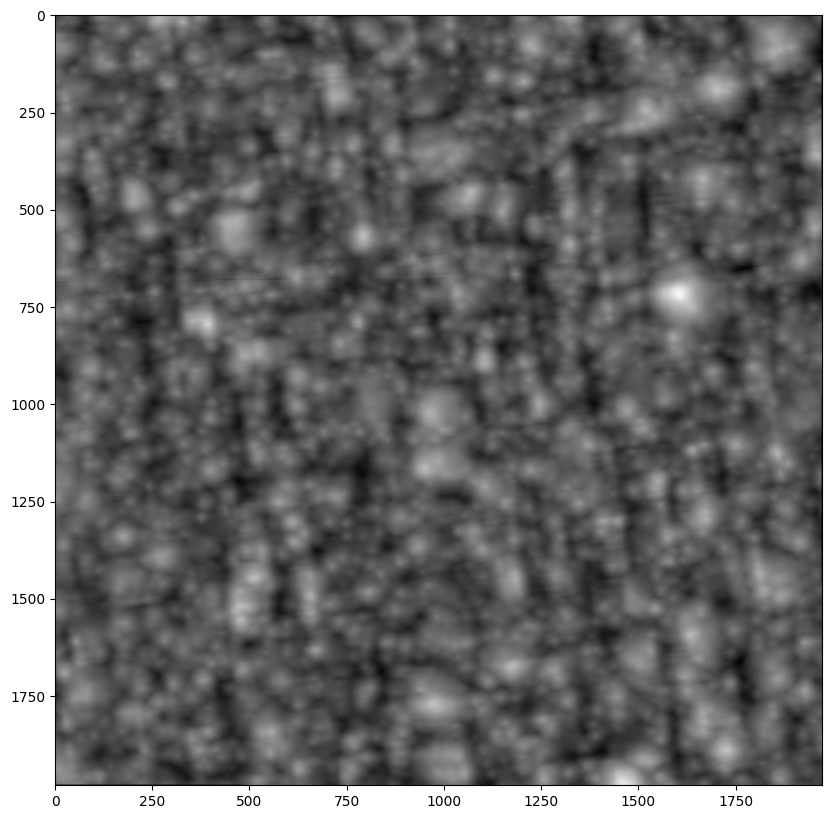

In [33]:
#compensor is computational expensive and cause kernel crush, this code stitch images without compensor
blender = Blender()
blender.prepare(final_corners, final_sizes)
for img, mask, corner in zip(cropped_final_imgs, cropped_final_masks, final_corners):
    blender.feed(img, mask, corner)
panorama, _ = blender.blend()
plot_image(panorama, (10,10))